# Building the LSTM Model

In [103]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from helper.helper import float_to_time, time_to_float, float_time_range, float_time_minus
import random
import tqdm
# Set seed for repeatability
def seed_everything(seed):
    np.random.seed(seed) # np random seed
    random.seed(seed) # py random seed
seed_everything(seed=1024)
import torch
print('torch version: ',torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
print('Running on ',torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch version:  2.5.1+cu124
Cuda available:  True
Running on  NVIDIA GeForce GTX 1060 6GB


In [104]:
X_lstm_tensor = torch.load('../../data/X_lstm_train.pt',weights_only=False)
t_lstm_tensor = torch.load('../../data/t_lstm_train.pt',weights_only=False)

In [105]:
nan_count = torch.isnan(X_lstm_tensor).sum().item()
print(f"Number of NaN values in X: {nan_count}")
nan_count = torch.isnan(t_lstm_tensor).sum().item()
print(f"Number of NaN values in t: {nan_count}")


Number of NaN values in X: 0
Number of NaN values in t: 0


In [106]:
X_lstm_tensor.shape, t_lstm_tensor.shape

(torch.Size([176307, 72, 38]), torch.Size([176307, 1]))

In [124]:
lstm_hr_df = pl.read_csv('../../data/lstm_hr_train_clean.csv')
bg_columns = ['bg', 'bg+1:00']
bg_max = lstm_hr_df['bg'].max()
bg_min = lstm_hr_df['bg'].min()
print(f"Max BG: {bg_max}, Min BG: {bg_min}")
bg_data = lstm_hr_df.select(bg_columns).to_numpy()

bg_scaler = MinMaxScaler()
bg_scaler.fit_transform(lstm_hr_df['bg'].to_numpy().reshape(-1, 1)) 


Max BG: 27.8, Min BG: 2.2


array([[0.14453125],
       [0.14453125],
       [0.14453125],
       ...,
       [0.33203125],
       [0.34375   ],
       [0.3671875 ]])

In [108]:
bg_columns = ['bg', 'bg+1:00']
bg_max = max(lstm_hr_df['bg'].max(), lstm_hr_df['bg+1:00'].max())
bg_min = min(lstm_hr_df['bg'].min(), lstm_hr_df['bg+1:00'].min())
print(f"Max BG: {bg_max}, Min BG: {bg_min}")

bg_data = lstm_hr_df.select(bg_columns).to_numpy()

bg_scaler = MinMaxScaler()
bg_scaler.fit([[bg_min, bg_min], [bg_max, bg_max]])


Max BG: 27.8, Min BG: 2.2


MinMaxScaler()

In [109]:
dataset = TensorDataset(X_lstm_tensor, t_lstm_tensor)

patient_columns = X_lstm_tensor[:, :, 2:10]
patient_columns
class_labels = patient_columns.argmax(dim=2)[:, 0]


train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.5,  # 50% for val+test
    stratify=class_labels
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,  # Half of temp for test, other half for val
    stratify=class_labels[temp_indices]
)

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [110]:
from collections import Counter
import numpy as np

# Function to count class distribution
def check_proportions(dataset, description):
    # Extract the one-hot encoded columns
    one_hot_columns = X_lstm_tensor[dataset.indices, :, 2:11]
    
    # Convert one-hot encoding to class labels
    class_labels = one_hot_columns.argmax(dim=2)[:, 0].numpy()  # Use the first timestep's label
    
    # Count occurrences
    class_counts = Counter(class_labels)
    total_samples = sum(class_counts.values())
    
    print(f"{description} Class Proportions:")
    for cls, count in sorted(class_counts.items()):
        print(f"Class {cls}: {count} samples ({count / total_samples:.2%})")
    print("-" * 50)

# Check proportions for each split
check_proportions(train_dataset, "Train")
check_proportions(val_dataset, "Validation")
check_proportions(test_dataset, "Test")


Train Class Proportions:
Class 0: 4198 samples (4.76%)
Class 1: 12577 samples (14.27%)
Class 2: 12343 samples (14.00%)
Class 3: 4144 samples (4.70%)
Class 4: 4192 samples (4.76%)
Class 5: 12727 samples (14.44%)
Class 6: 12278 samples (13.93%)
Class 7: 12649 samples (14.35%)
Class 8: 13045 samples (14.80%)
--------------------------------------------------
Validation Class Proportions:
Class 0: 2150 samples (4.88%)
Class 1: 6289 samples (14.27%)
Class 2: 6171 samples (14.00%)
Class 3: 2072 samples (4.70%)
Class 4: 2095 samples (4.75%)
Class 5: 6364 samples (14.44%)
Class 6: 6139 samples (13.93%)
Class 7: 6325 samples (14.35%)
Class 8: 6472 samples (14.68%)
--------------------------------------------------
Test Class Proportions:
Class 0: 2122 samples (4.81%)
Class 1: 6289 samples (14.27%)
Class 2: 6172 samples (14.00%)
Class 3: 2072 samples (4.70%)
Class 4: 2096 samples (4.76%)
Class 5: 6363 samples (14.44%)
Class 6: 6138 samples (13.93%)
Class 7: 6325 samples (14.35%)
Class 8: 6500 sa

In [ ]:
for X, t in train_loader:
    print('X.shape:', X[:,-1,13], 't.shape:', t.shape)
    break
for X, t in val_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in test_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break

X.shape: tensor([0.2814, 0.3223, 0.3338, 0.1320, 0.4245, 0.1456, 0.4408, 0.4164, 0.3439,
        0.3602, 0.3155, 0.2053, 0.4523, 0.2882, 0.1503, 0.2783, 0.3067, 0.2207,
        0.0643, 0.2938, 0.3798, 0.3595, 0.2988, 0.2799, 0.2896, 0.2925, 0.2255,
        0.4190, 0.5071, 0.1029, 0.1754, 0.3243]) t.shape: tensor([[0.3711],
        [0.3398],
        [0.0781],
        [0.2266],
        [0.0664],
        [0.1445],
        [0.3047],
        [0.5312],
        [0.1445],
        [0.1484],
        [0.2109],
        [0.2852],
        [0.2227],
        [0.1211],
        [0.1367],
        [0.4688],
        [0.2109],
        [0.2070],
        [0.4336],
        [0.2109],
        [0.4141],
        [0.4570],
        [0.1602],
        [0.2344],
        [0.2617],
        [0.3906],
        [0.1758],
        [0.3945],
        [0.1094],
        [0.1758],
        [0.4297],
        [0.1172]])
X.shape: torch.Size([32, 72, 38]) t.shape: torch.Size([32, 1])
X.shape: torch.Size([32, 72, 38]) t.shape: torch.Size

In [112]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        last_hidden_state = output[:, -1, :]
        prediction = self.fc(last_hidden_state)
        return prediction
    

In [113]:
import torch.optim as optim
import torch.nn as nn

INPUT_SIZE = X_lstm_tensor.shape[-1]
HIDDEN_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 15

LSTMReg = LSTMRegressor(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
LSTMReg.to(device)

criterion = nn.MSELoss()  # Built-in PyTorch MSE loss
optimizer = optim.Adam(LSTMReg.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    LSTMReg.train()
    train_loss = 0.0  # For accumulating training loss
    
    for X_batch, t_batch in train_loader:
        X_batch, t_batch = X_batch.to(device), t_batch.to(device)
        
        optimizer.zero_grad()  # Clear gradients
        predictions = LSTMReg(X_batch)  # Forward pass
        
        loss = criterion(predictions, t_batch)  # Compute MSE loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        
        train_loss += loss.item()  # Accumulate batch loss

    # Compute average train loss (MSE)
    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    LSTMReg.eval()
    val_loss = 0.0  # For accumulating validation loss
    with torch.no_grad():  # Disable gradient computation for validation
        for X_val_batch, t_val_batch in val_loader:
            X_val_batch, t_val_batch = X_val_batch.to(device), t_val_batch.to(device)
            val_predictions = LSTMReg(X_val_batch)  # Forward pass
            
            loss = criterion(val_predictions, t_val_batch)  # Compute MSE loss
            val_loss += loss.item()  # Accumulate batch loss

    # Compute average validation loss (MSE)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train MSE: {avg_train_loss:.4f}, Val MSE: {avg_val_loss:.4f}")


Epoch [1/15], Train MSE: 0.0073, Val MSE: 0.0064
Epoch [2/15], Train MSE: 0.0061, Val MSE: 0.0060
Epoch [3/15], Train MSE: 0.0058, Val MSE: 0.0058
Epoch [4/15], Train MSE: 0.0057, Val MSE: 0.0059
Epoch [5/15], Train MSE: 0.0057, Val MSE: 0.0058
Epoch [6/15], Train MSE: 0.0056, Val MSE: 0.0057
Epoch [7/15], Train MSE: 0.0056, Val MSE: 0.0056
Epoch [8/15], Train MSE: 0.0055, Val MSE: 0.0056
Epoch [9/15], Train MSE: 0.0055, Val MSE: 0.0057
Epoch [10/15], Train MSE: 0.0054, Val MSE: 0.0055
Epoch [11/15], Train MSE: 0.0054, Val MSE: 0.0055
Epoch [12/15], Train MSE: 0.0053, Val MSE: 0.0055
Epoch [13/15], Train MSE: 0.0052, Val MSE: 0.0054
Epoch [14/15], Train MSE: 0.0052, Val MSE: 0.0054
Epoch [15/15], Train MSE: 0.0052, Val MSE: 0.0054


In [114]:
LSTMReg.eval()

squared_error_total = 0.0  
num_samples = 0 

with torch.no_grad():
    for X_test_batch, t_test_batch in test_loader:
        X_test_batch, t_test_batch = X_test_batch.to(device), t_test_batch.to(device)
        
        test_predictions = LSTMReg(X_test_batch)
        
        t_test_batch = t_test_batch.view(-1, 1)
        test_predictions = test_predictions.view(-1, 1)

        combined_data = np.hstack([t_test_batch.cpu().numpy(), test_predictions.cpu().numpy()])
        
        t_test_batch_inverse, test_predictions_inverse = bg_scaler.inverse_transform(combined_data).T
        t_test_batch_inverse = torch.from_numpy(t_test_batch_inverse)
        test_predictions_inverse = torch.from_numpy(test_predictions_inverse)


        squared_error = (test_predictions_inverse - t_test_batch_inverse) ** 2

        squared_error_total += squared_error.sum().item() 
        num_samples += len(t_test_batch_inverse)  


average_squared_error = squared_error_total / num_samples


test_rmse = np.sqrt(average_squared_error)

print(f"Test RMSE: {test_rmse:.4f}")


Test RMSE: 1.8847


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

LSTMReg.eval()

def calculate_rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())

test_rmse = 0.0
num_batches = 0

all_targets = []
all_predictions = []
last_bg = []

with torch.no_grad():  
    for X_test_batch, t_test_batch in test_loader:
        X_test_batch, t_test_batch = X_test_batch.to(device), t_test_batch.to(device)
        
        test_predictions = LSTMReg(X_test_batch)
        
        # Flatten both targets and predictions for proper shape handling
        t_test_batch = t_test_batch.view(-1, 1)
        test_predictions = test_predictions.view(-1, 1)
        
        # Collect last bg values (assuming 13th index is where bg is located)
        last_bg_batch = X_test_batch[:,-1,13].cpu().numpy()
        
        # Inverse transform the last bg, targets, and predictions
        last_bg_inverse = bg_scaler.inverse_transform(last_bg_batch.reshape(-1, 1))
        t_test_batch_inverse = bg_scaler.inverse_transform(t_test_batch.cpu().numpy())
        test_predictions_inverse = bg_scaler.inverse_transform(test_predictions.cpu().numpy())
        
        # Convert back to tensors
        t_test_batch_inverse = torch.from_numpy(t_test_batch_inverse)
        test_predictions_inverse = torch.from_numpy(test_predictions_inverse)

        # Append all values to lists
        all_targets.append(t_test_batch_inverse.cpu().numpy())
        all_predictions.append(test_predictions_inverse.cpu().numpy())
        last_bg.append(last_bg_inverse)

        # Calculate RMSE for the current batch and update total
        test_rmse += calculate_rmse(test_predictions_inverse, t_test_batch_inverse).item()
        num_batches += 1

# Concatenate the results for all batches
all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)
all_last_bg = np.concatenate(last_bg)

# Calculate the average RMSE over all batches
test_rmse /= num_batches
print(f"Test RMSE: {test_rmse:.4f}")

# Sort the data based on targets
sorted_indices = np.argsort(all_targets)  
sorted_targets = all_targets[sorted_indices] 
sorted_predictions = all_predictions[sorted_indices]  
sorted_last_bg = all_last_bg[sorted_indices]

# Check lengths for debugging
print(len(sorted_targets), len(sorted_predictions), len(sorted_last_bg))


Test RMSE: 1.8585
44077 44077 44077


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

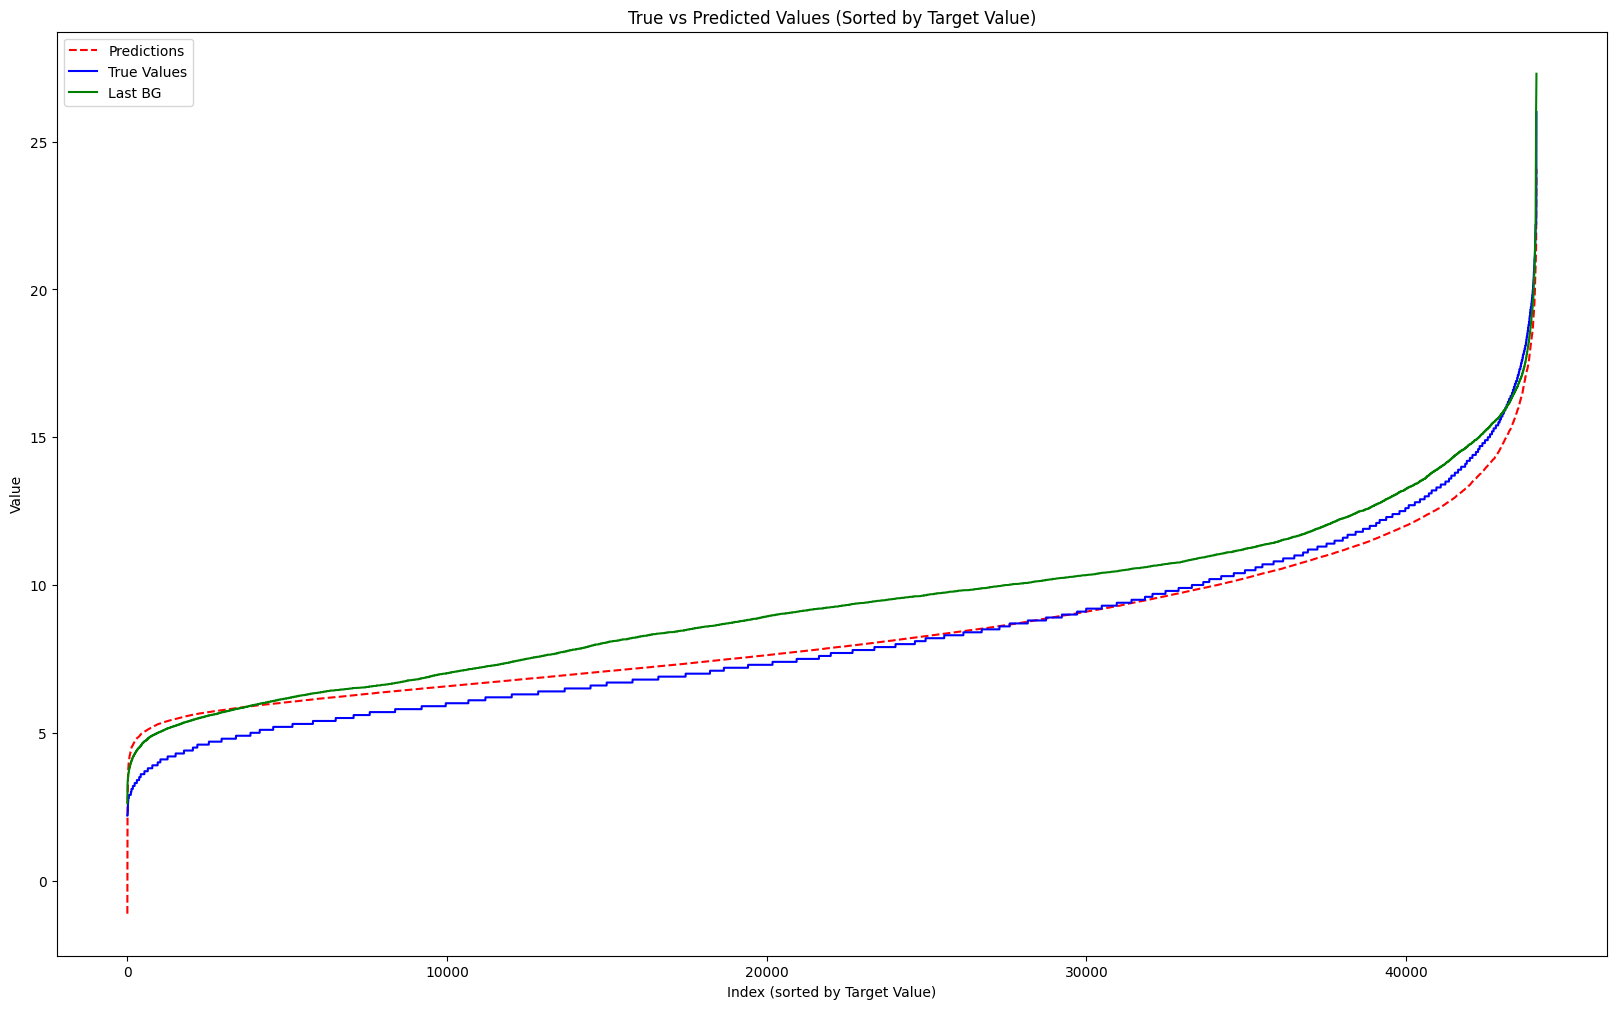

In [156]:
start,end = 0, len(sorted_targets)
plt.figure(figsize=(20, 12))
plt.plot(sorted(all_predictions), label='Predictions', color='red', linestyle='--')
plt.plot(sorted(all_targets), label='True Values', color='blue')
plt.plot(sorted(all_last_bg), label='Last BG', color='green')

plt.xlabel('Index (sorted by Target Value)')
plt.ylabel('Value')
plt.title('True vs Predicted Values (Sorted by Target Value)')
plt.legend()
plt.show()

In [ ]:
X_

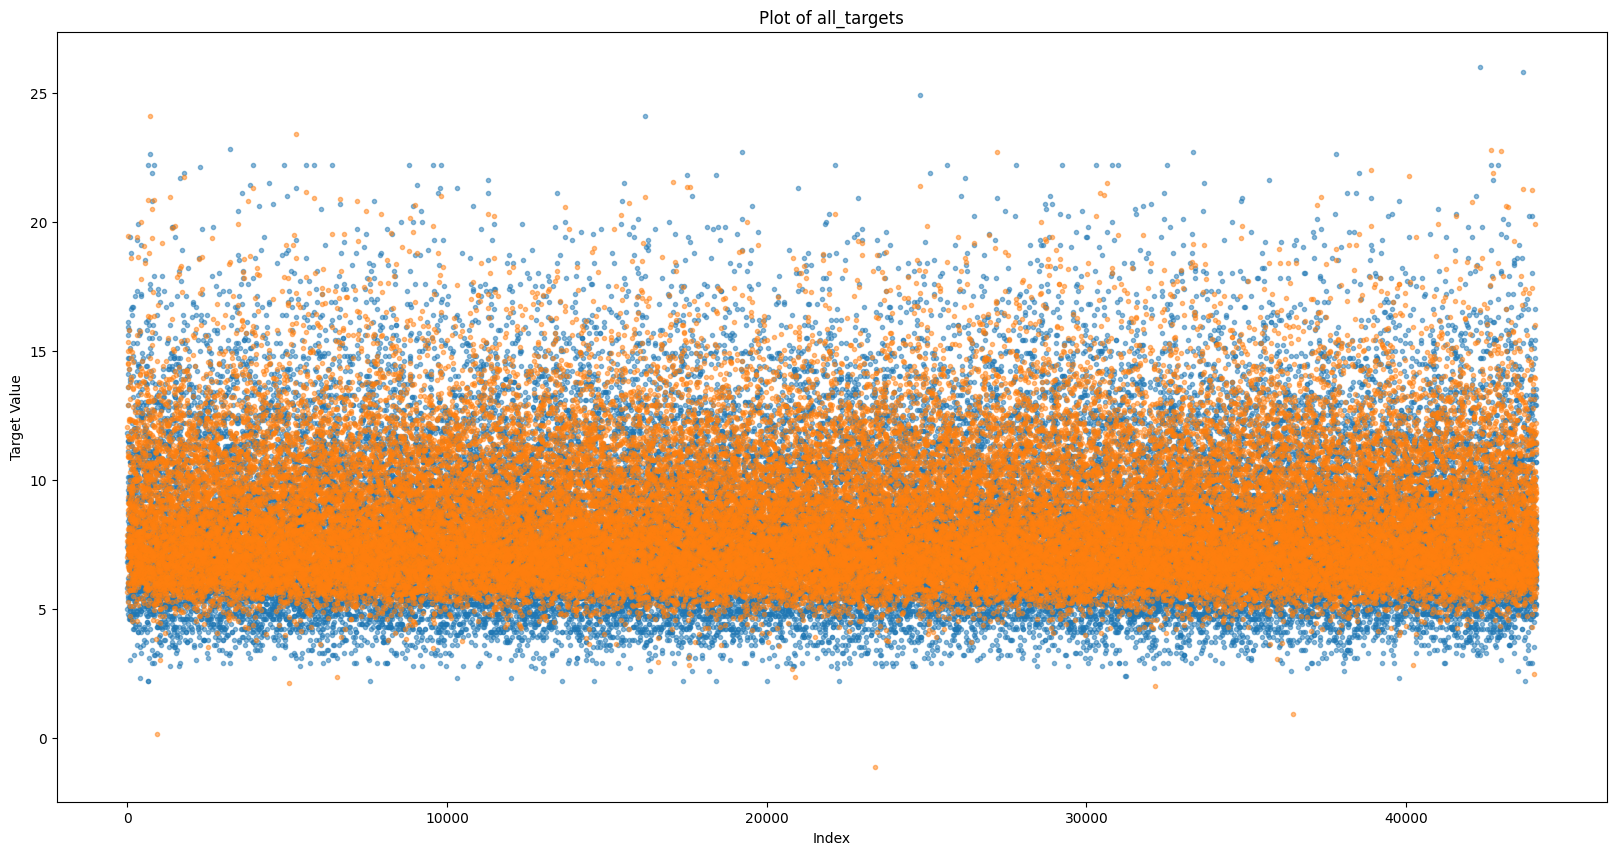

In [117]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(all_targets)), all_targets, '.', alpha=0.5)
plt.plot(np.arange(len(all_predictions)), all_predictions, '.', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Plot of all_targets')
plt.show()


In [118]:
X_lstm_tensor = torch.load('../../data/X_lstm_test.pt',weights_only=False)

submission_ids = X_lstm_tensor[:, 0, -1]
X_lstm_tensor = X_lstm_tensor[:,:,:-1].to(device)

all_ids = []
for ids in submission_ids:
    all_ids.append([float_id_converter(ids),ids])

In [119]:
pandas_ids = pd.DataFrame(all_ids, columns=['id', 'float_id'])
pandas_ids.describe()
pandas_ids

,id,float_id
0,p02_25923,tensor(2.2592)
1,p11_24645,tensor(11.2465)
2,p02_25873,tensor(2.2587)
3,p10_25621,tensor(10.2562)
4,p22_138,tensor(22.0014)
...,...,...
3639,p16_215,tensor(16.0021)
3640,p01_8651,tensor(1.0865)
3641,p15_255,tensor(15.0026)
3642,p22_62,tensor(22.0006)


In [120]:
def float_id_converter(float_id):
    # Extract the integer part and fractional part
    int_part = int(float_id)
    frac_part = np.round((float_id - int_part) * 1e5)
    
    formatted_int_part = f'{int_part:02}'  
    formatted_frac_part = f'{int(frac_part)}'
    
    return f'p{formatted_int_part}_{formatted_frac_part}'

float_id_converter(3.0001)



'p03_10'

In [121]:
LSTMReg.eval()


with torch.no_grad():  
    predictions = LSTMReg(X_lstm_tensor).cpu().numpy()

# Now, prepare the output in the desired format
output_lines = []
for i in range(len(submission_ids)):
    float_id = submission_ids[i].item()  # Convert to scalar if it's a tensor
    id_str = float_id_converter(float_id)  # Convert to the desired string format
    
    # Assuming that bg+1:00 is the first predicted value
    bg_value = predictions[i, 0]  # You can adjust this if your model outputs multiple columns
    bg_value = bg_scaler.inverse_transform([[bg_value]])  # Inverse transform
    bg_value = bg_value[0, 0]  # Extract the scalar value
    print(bg_value)
    # Format the output
    output_lines.append(f"{id_str},{bg_value}")  # Format bg_value to 2 decimal places

# Save or print the output
output = "\n".join(output_lines)

# Optionally, write to a CSV file
with open("submission_output.csv", "w") as f:
    f.write("id,bg+1:00\n")
    f.write(output)


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,2)